In [1]:
# My custom class wherein are libraries like pandas ,mpl,np etc.
from preprocessor import *
from imblearn.over_sampling import SMOTE
prep = Preprocessor()

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')



Using TensorFlow backend.


In [2]:
td = pd.concat([train,test],ignore_index=True,sort=False)
#td['Pclass'] = td['Pclass'].astype(object)
#prep.overview(train)

In [3]:
# save PassengerId for final submission
passengerId = test.PassengerId

In [4]:
# create indexes to separate data later on
train_idx = len(train)
test_idx = len(td) - len(test)

In [5]:
# PassengerId can be removed from data for now
td.drop('PassengerId', axis=1, inplace=True)

In [6]:
td.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
td['Title'] = td.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

#Normalize the titles
normalized_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}

# map the normalized titles to the current titles 
td.Title = td.Title.map(normalized_titles)

print(td.Title.value_counts())
td.isnull().sum().sort_values()

Mr         757
Miss       262
Mrs        200
Master      61
Officer     23
Royalty      6
Name: Title, dtype: int64


Pclass         0
Name           0
Sex            0
SibSp          0
Parch          0
Ticket         0
Title          0
Fare           1
Embarked       2
Age          263
Survived     418
Cabin       1014
dtype: int64

In [8]:
# group by Sex, Pclass, and Title 
grouped = td.groupby(['Sex','Pclass', 'Title'])  # view the median Age by the grouped features 
grouped.Age.median()

Sex     Pclass  Title  
female  1       Miss       30.0
                Mrs        45.0
                Officer    49.0
                Royalty    39.0
        2       Miss       20.0
                Mrs        30.0
        3       Miss       18.0
                Mrs        31.0
male    1       Master      6.0
                Mr         41.5
                Officer    52.0
                Royalty    40.0
        2       Master      2.0
                Mr         30.0
                Officer    41.5
        3       Master      6.0
                Mr         26.0
Name: Age, dtype: float64

In [9]:
# apply the grouped median value on the Age NaN
td.Age = grouped.Age.apply(lambda x: x.fillna(x.median()))

In [10]:
# fill Cabin NaN with U for unknown
td.Cabin = td.Cabin.fillna('U')

In [11]:
# find most frequent Embarked value and store in variable
most_embarked = td.Embarked.value_counts().index[0]

# fill NaN with most_embarked value
td.Embarked = td.Embarked.fillna(most_embarked)

In [12]:
# fill NaN with median fare
td.Fare = td.Fare.fillna(td.Fare.median())

In [13]:
# view the percentage of those that survived vs. those that died in the Titanic
td.Survived.value_counts(normalize=True)

0.0    0.616162
1.0    0.383838
Name: Survived, dtype: float64

In [14]:
# view the percentage of females vs. males that died in the Titanic
td.Sex.value_counts(normalize=True)

male      0.644003
female    0.355997
Name: Sex, dtype: float64

In [15]:
# group by sex
group_by_sex = td.groupby('Sex')

# survival rate by sex
group_by_sex.Survived.mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [16]:
# group by passenger class and sex
group_class_sex = td.groupby(['Pclass', 'Sex'])

# survival rates by class and sex
group_class_sex.Survived.mean()

Pclass  Sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
Name: Survived, dtype: float64

<Figure size 864x576 with 0 Axes>

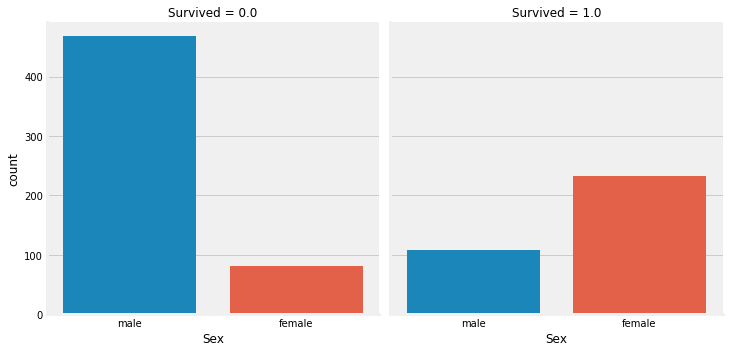

In [17]:
# plot by Survided, Sex
plt.figure(figsize=(12,8))
_ = sns.factorplot(x='Sex', col='Survived', data=td, kind='count');

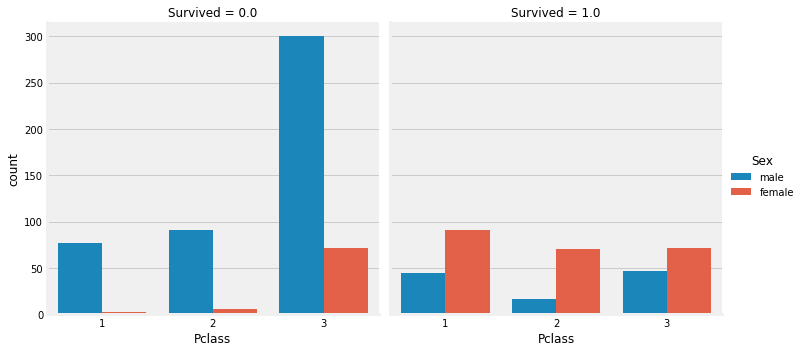

In [18]:
# plot by Pclass, Sex, Survived
_ = sns.factorplot(x='Pclass', hue='Sex', col='Survived', data=td, kind='count')

In [19]:
# get stats on all the features
td.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.383838,2.294882,29.278205,0.498854,0.385027,33.281086
std,0.486592,0.837836,13.446690,1.041658,0.865560,51.741500
min,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,26.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,36.500000,1.000000,0.000000,31.275000
max,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [20]:
# size of families (including the passenger)
td['FamilySize'] = td.Parch + td.SibSp + 1

In [21]:
# map first letter of cabin to itself
td.Cabin = td.Cabin.map(lambda x: x[0])

# view normalized count
td.Cabin.value_counts(normalize=True)

U    0.774637
C    0.071811
B    0.049656
D    0.035141
E    0.031322
A    0.016807
F    0.016043
G    0.003820
T    0.000764
Name: Cabin, dtype: float64

In [22]:
td.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,Mr,2
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,Mrs,2
2,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,Miss,1
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,Mrs,2
4,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,Mr,1


In [23]:
# Convert the male and female groups to integer form
td.Sex = td.Sex.map({"male": 0, "female":1})

In [24]:
# create dummy variables for categorical features
pclass_dummies = pd.get_dummies(td.Pclass, prefix="Pclass")
title_dummies = pd.get_dummies(td.Title, prefix="Title")
cabin_dummies = pd.get_dummies(td.Cabin, prefix="Cabin")
embarked_dummies = pd.get_dummies(td.Embarked, prefix="Embarked")

In [25]:
# concatenate dummy columns with main dataset
titanic_dummies = pd.concat([td, pclass_dummies, title_dummies, cabin_dummies, embarked_dummies], axis=1)

# drop categorical fields
titanic_dummies.drop(['Pclass', 'Title', 'Cabin', 'Embarked', 'Name', 'Ticket'], axis=1, inplace=True)

titanic_dummies.head()

,Survived,Sex,Age,SibSp,Parch,Fare,FamilySize,Pclass_1,Pclass_2,Pclass_3,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0,22.0,1,0,7.2500,2,0,0,1,...,0,0,0,0,0,0,1,0,0,1
1,1.0,1,38.0,1,0,71.2833,2,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,7.9250,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,1.0,1,35.0,1,0,53.1000,2,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0.0,0,35.0,0,0,8.0500,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1


In [26]:
# create train and test data
train = titanic_dummies[ :train_idx]
test = titanic_dummies[test_idx: ]

# convert Survived back to int
train.Survived = train.Survived.astype(int)

In [63]:
# create X and y for data and target values
X = train.drop('Survived', axis=1).values
y = train.Survived.values

In [64]:
smote = SMOTE(ratio='minority')
# The label better be an int
X1, y = smote.fit_sample(X, y)
sc = MinMaxScaler()
X = sc.fit_transform(X1)
#testy = sc.fit_transform(testy)
#testy

In [65]:
#Dataset is balanced after applying smote algorithm
print(Counter(y))
y.dtype

Counter({0: 549, 1: 549})


dtype('int64')

In [66]:
# create array for test set
X_test = test.drop('Survived', axis=1).values

In [31]:
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [67]:
# create param grid object
log_params = dict(
    C = np.logspace(-5, 8, 15),
    penalty = ['l1', 'l2']
)

In [68]:
# instantiate logistic regressor
log = LogisticRegression()

# load param grid and log model into GridSearcCV
logreg_cv = GridSearchCV(estimator=log, param_grid=log_params, cv=5)

# fit model
logreg_cv.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08]),
                         'penalty': ['l1', 

In [69]:
# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 0.4393970560760795, 'penalty': 'l1'}
Best score is 0.825136612021858


In [35]:
# predict on test set for submission
# log_pred = logreg_cv.predict(X_test)

In [70]:
# create param grid object
forrest_params = dict(
    max_depth = [n for n in range(9, 14)],
    min_samples_split = [n for n in range(4, 11)],
    min_samples_leaf = [n for n in range(2, 5)],
    n_estimators = [n for n in range(10, 60, 10)],
)



In [71]:
# instantiate Random Forest model
forrest = RandomForestClassifier()

In [72]:
# build and fit model
forest_cv = GridSearchCV(estimator=forrest, param_grid=forrest_params, cv=5)
forest_cv.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [73]:
# print("Best score: {}".format(forest_model.best_score_))
# print("Optimal params: {}".format(forest_model.best_estimator_))
print("Best score: {}".format(forest_cv.best_score_))
print("Optimal params: {}".format(forest_cv.best_estimator_))

Best score: 0.8506375227686703
Optimal params: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [74]:
# random forrest prediction on test set
forrest_pred = forest_cv.predict(X_test)

In [75]:
# dataframe with predictions
kaggle = pd.DataFrame( {'PassengerId': passengerId, 'Survived': forrest_pred} )

In [76]:
print(kaggle.shape)
# ensure df is in the right format
kaggle.head(10)

(418, 2)


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,0
9,901,0


In [77]:
# save to csv
kaggle.to_csv('titanic_pred1.csv', index=False)

In [80]:
x = pd.read_csv('titanic_pred1.csv',index_col=0)
x.head(30)

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
897,0
898,0
899,0
900,0


In [12]:
from sklearn.model_selection import GridSearchCV# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}